In [11]:
import matplotlib.pyplot as plt
import numpy as np

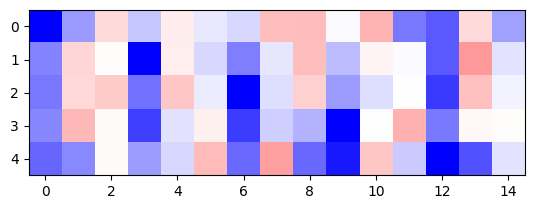

In [22]:
rng = np.random.default_rng(0)
Nf, Nd = 5, 3  # 5 fingers, 3 channels/finger
N = Nf * Nd  # N channels
T = 20  # trial duration
d = 5  # simulated dimensionality (including flexor bias)

w_f, w_p, w_b = .8, .1, .5

# first we have single finger "synergies"
single_finger = np.eye(N)

# then some additional patterns
add_patterns = rng.standard_normal((N, d))

# then the flexor bias
flexCh = np.arange(0, N, Nd, dtype=int)
flexBias = np.zeros(N)
flexBias[flexCh] = 1

# basis functions
A = np.c_[w_f * single_finger, w_p * add_patterns, w_b * flexBias]

# set strength of enslaving
bias_strength = .1
flexBias = np.outer(flexBias, flexBias.T)
coupling = .1
C = np.full((N, N), coupling, dtype=float)
C += 0.02 * rng.standard_normal((N, N))
C += bias_strength * flexBias
np.fill_diagonal(C, 1.0)

# recruitment of basis vectors in each condition
I = np.eye(N)
B_f = I.reshape(Nf, Nd, N)
B_p = rng.standard_normal((Nf, Nd, d))
B_b = np.c_[np.ones((Nf, 1)), np.zeros((Nf, 2))]
B = np.c_[B_f, B_p, B_b[:, :, None]]

# Create a force profile
t = np.linspace(0, 1, T)
profile = np.sin(np.pi * t) ** 2

# example trials
n_trials = 100
F = np.zeros((n_trials, T, N), dtype=float)
fingers = np.zeros(n_trials, dtype=int)
dirs = np.zeros((n_trials, 3), dtype=float)
for tr in range(n_trials):
    f = rng.integers(0, Nf)          # which finger is instructed
    v = np.array([-1, 0, 0], dtype=float)       # movement direction in 3D
    v /= (np.linalg.norm(v) + 1e-12)
    amp = 1 + .2 * rng.standard_normal() # movement amplitude
    z_vec = v[0] * B[f, 0] + v[1] * B[f, 1] + v[2] * B[f, 2] # (d,)
    Z = (amp * profile)[:, None] * z_vec[None, :] # (T, d)
    X = Z @ A.T
    noise=.0
    X += noise * rng.standard_normal(X.shape)
    Ft = X #@ C.T
    F[tr] = Ft
    fingers[tr] = f

F_f = []
for f in range(Nf):
    F_f.append(F[fingers == f, 10].mean(axis=0))
plt.imshow(F_f, cmap='bwr', vmax=1, vmin=-1)

In [25]:
F_concat = F.reshape(n_trials * T, -1)

F_concat.shape

(2000, 15)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

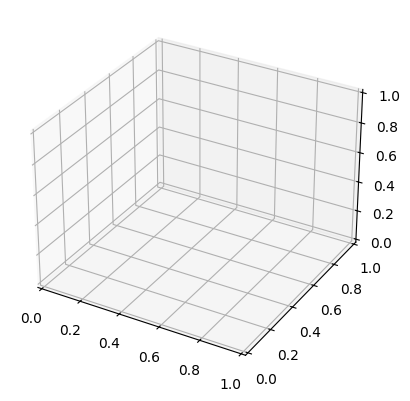

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
for f in range(Nf):
    for tr in range(n_trials):
        ax.plot(F[:, :, f, 0], F[:, :, f, 1], F[:, :, f, 2], color=color[f])

plt.show()